# TD2C-D2C, ideas for different MBs (notebook for comparison)
This notebook wants to compare different formulations of `TD2C` method, each of them with a different way of computing the MB:

MB formulations:

1. **Past MB**: Classic TD2C's MB but considering a bigger lag in the past for the variables under exam. Ex: we want to discoveer the causal path X^(t-1)_i -> X_j and normally we would consider X_i^(t-1), X_i^(t), X_i^(t+1) and X_j^(t-1), X_j^(t), X_j^(t+1) but here we ho back in the past and try to include also  X_i^(t-2), X_i^(t-3), X_i^(t-4) and X_j^(t-2), X_j^(t-3), X_j^(t-4) in X_i and X_j's MBs. 
This is done by setting the `past_lag` parameter in the `D2C` class.

2. **TD2C-D2C MIX**: We combine TD2C's MB with a preliminary ranking of the variables as was done in D2C, trying to reduce the computational cost of D2C and maybe find a better balance for the curse of dimentionality.

3. **MBMB**: D2C's MB but enlarged, including the most relevat variables for the most relevant variables for X_i and X_j.


With this notebook you'll be able to generate the data, generate the decriptors for each of the MB formulations, obtain a classification result and plot the results for comparison.


# Settings

## Packages

In [1]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score

from d2c.data_generation.builder import TSBuilder
from d2c.descriptors_generation import D2C, DataLoader
from d2c.benchmark import D2CWrapper

## Parameters setting

In [2]:
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 2 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = 60 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples

# Data Generation
Data are generated with the `TSBuilder` class and saved in a specific folder. Then, the code checks for missing datasets in the folder and keeps running untill all the possible combinations of parameters have genereted a dataset.

In [11]:
# SET THE TSBUILDER WITH THE DESIRED PARAMETERS
def run_process(params):
    """
    Run a single process of the data generation.
    """
    process, n_variables, max_neighborhood_size, noise_std = params
    try:
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=42, 
                              max_attempts=200,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# BUILD THE DATA
if __name__ == '__main__':
    """
    This script generates the data for different parameters: processes, number of variables, neighborhood sizes and noise levels.
    The data is saved in the .data folder.
    The if __name__ == '__main__': is used to avoid multiprocessing issues in Jupyter notebooks, i.e. the script is run as a script and not
    as a module as it would have been if the script was imported, with the __name__ being the name of the module.
    If the script is imported, the __name__ is the name of the module, if it is run as a script, the __name__ is __main__.
    So, to run this script in a Jupyter notebook, we write the code inside the if __name__ == '__main__': block, while, if we want to import
    the functions from this script, we write "from script import run_process".
    """
    parameters = [(process, n_variables, max_neighborhood_size, noise_std)
                    for process in [1, 2, 3, 4, 6, 7, 8, 9] # , 10, 11, 12, 13, 14, 15, 16, 18, 19, 20
                    for n_variables in [5] # , 10, 25
                    for max_neighborhood_size in [2] # , 4, 8
                    for noise_std in [0.01]] # , 0.005, 0.001

    with Pool(processes=N_JOBS) as pool:
        pool.map(run_process, parameters)


# Function to check for missing files
def check_missing_files():
    missing = []
    for process in [1, 2, 3, 4, 6, 7, 8, 9]:  # , 10, 11, 12, 13, 14, 15, 16, 18, 19, 20
        for n_variables in [5]:  # , 10, 25
            for max_neighborhood_size in [2]:  # , 4, 8
                for noise_std in [0.01]:  # , 0.005, 0.001
                    filename = f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
                    if not os.path.exists(filename):
                        missing.append(filename)
    return missing

# Function to run the process
def run_process(params):
    process, n_variables, max_neighborhood_size, noise_std = params
    try:  # we change the seed and increase the max_attempts
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=24, 
                              max_attempts=400,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# CHECK FOR MISSING FILES (IT CHEKS THE FILES WITH A DIFFERENT SEED AND MORE MAX_ATTEMPTS UNTILL MISSING IS EMPTY)
if __name__ == '__main__':
    while True:
        missing = check_missing_files()
        if not missing:
            break

        parameters = []
        for missing_file in missing:
            process = int(missing_file.split('/')[-1].split('_')[0][1:])
            n_variables = int(missing_file.split('/')[-1].split('_')[1][1:])
            max_neighborhood_size = int(missing_file.split('/')[-1].split('_')[2][2:])
            noise_std = float(missing_file.split('/')[-1].split('_')[3][1:-4])
            parameters.append((process, n_variables, max_neighborhood_size, noise_std))

        with Pool(processes=N_JOBS) as pool:
            pool.map(run_process, parameters)

len(os.listdir('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data'))


P3_N5_Nj2_n0.01 done
P4_N5_Nj2_n0.01 done
P9_N5_Nj2_n0.01 done
P8_N5_Nj2_n0.01 done
P6_N5_Nj2_n0.01 done
P2_N5_Nj2_n0.01 done
P1_N5_Nj2_n0.01 done
P7_N5_Nj2_n0.01 done


18

# Descriptors Generation & Classification

## Regression Estimation of MI

### D2C (& D2C but without contemporaneous nodes) 

#### Descriptors Generation

In [133]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'original',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/8 [00:00<?, ?it/s]

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y: 

 12%|█▎        | 1/8 [00:15<01:47, 15.38s/it]

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)



Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y:

 25%|██▌       | 2/8 [00:28<01:23, 13.86s/it]

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)




Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)



Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (24

 38%|███▊      | 3/8 [00:42<01:10, 14.18s/it]

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (

 50%|█████     | 4/8 [01:12<01:20, 20.16s/it]

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)




Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y:

 62%|██████▎   | 5/8 [01:25<00:53, 17.81s/it]

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: 

 75%|███████▌  | 6/8 [01:39<00:33, 16.51s/it]

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)


Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (

 88%|████████▊ | 7/8 [01:53<00:15, 15.54s/it]

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)




Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)Shape of X: (245, 29), Shape of Y: (245,)
Shape of X: (245, 29), Shape of Y: (245,)

Shape of X: (245, 29), Shape of Y: 

100%|██████████| 8/8 [02:22<00:00, 17.79s/it]


#### Run Classifier

In [134]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [135]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_rocs_process = {}
    d2c_precision_process = {}
    d2c_recall_process = {}
    d2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_rocs_process[gen_process_number] = rocs
        d2c_precision_process[gen_process_number] = precisions
        d2c_recall_process[gen_process_number] = recalls
        d2c_f1_process[gen_process_number] = f1s

100%|██████████| 8/8 [00:56<00:00,  7.07s/it]


#### Save Results

In [136]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_R_N5.pkl'), 'wb') as f:
    everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

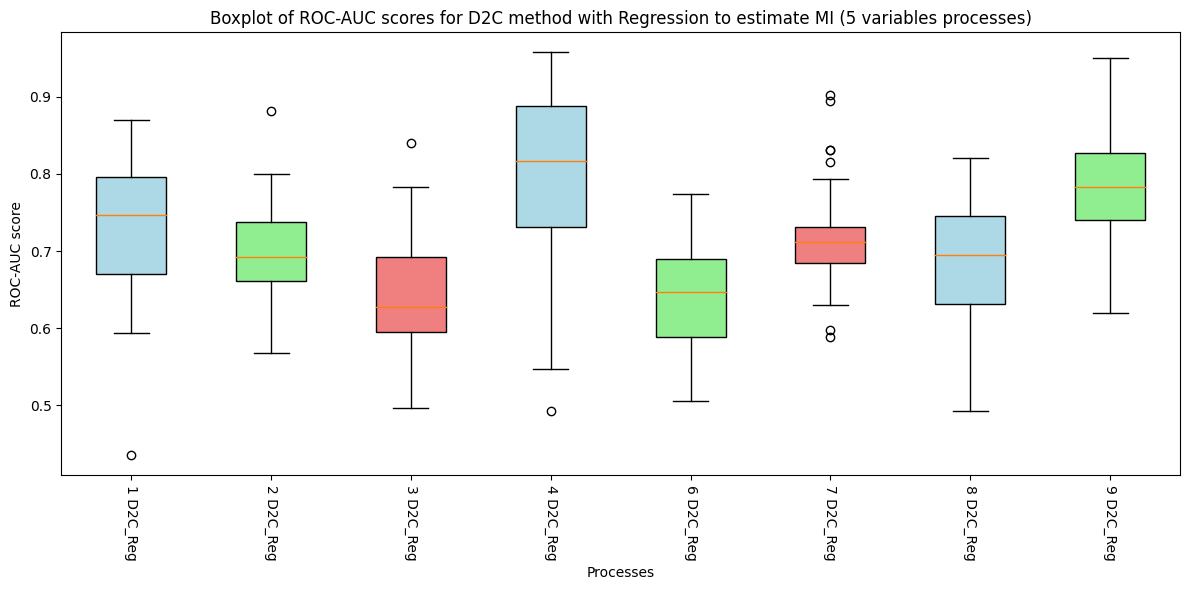

In [138]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_d2c_R_N5.pkl'), 'rb') as f:
    D2C_rocs_process, D2C_precision_process, D2C_recall_process, D2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for D2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C (& TD2C but without contrmporaneous nodes)

#### Descriptors Generation

In [5]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

100%|██████████| 18/18 [01:25<00:00,  4.77s/it]


#### Run Classifier

In [6]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [7]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/my

#### Save Results

In [8]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N10.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N25.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

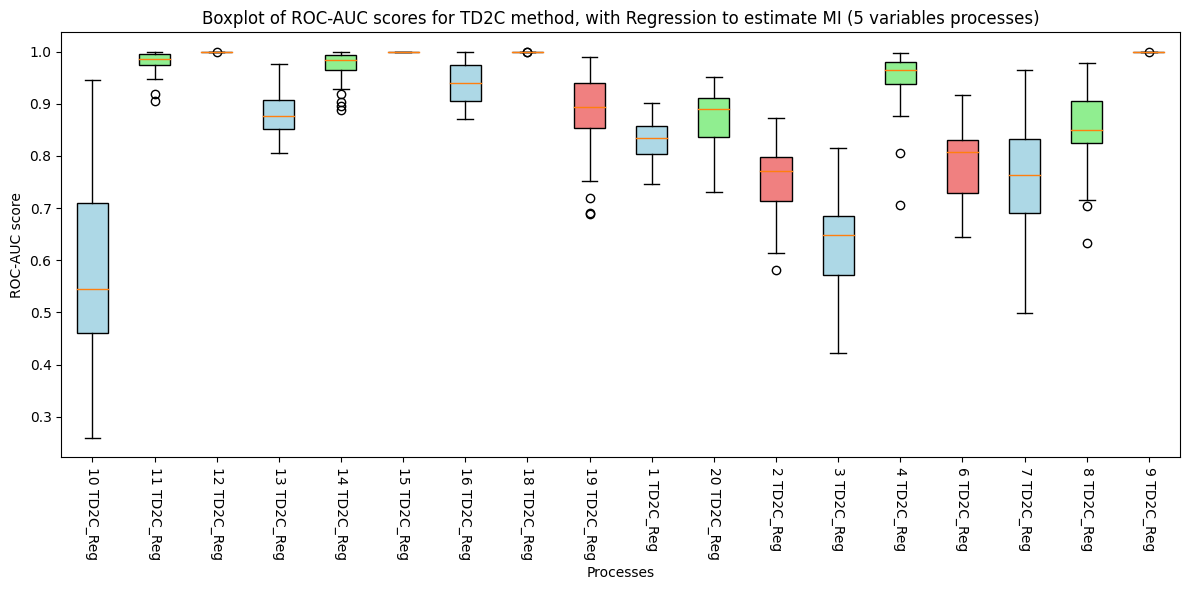

In [17]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process, TD2C_precision_process, TD2C_recall_process, TD2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking (All methods)

#### Descriptors Generation

In [44]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################

# SET FOLDER
cartella = 2
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3, 
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking
# 110 = TD2C_+Ranking_1 with ten variables from ranking
# 5 = TD2C_+Ranking_4 with two variables from ranking
# 6 = TD2C_+Ranking_5 with three variables from ranking

if cartella == 1:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    ts_rank = 'ts_rank'
    vars_to_keep = 1
elif cartella == 11:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 2
elif cartella == 111:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 3
elif cartella == 110:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/10_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 10
elif cartella == 2:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_2/'
    ts_rank = 'ts_rank_2'
    vars_to_keep = 1
elif cartella == 3:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_3/'
    ts_rank = 'ts_rank_3'
    vars_to_keep = 1
elif cartella == 4:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    ts_rank = 'ts_rank_no_cont' 
    vars_to_keep = 1
elif cartella == 5:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_4/'
    ts_rank = 'ts_rank_4' 
    vars_to_keep = 1
elif cartella == 6:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_5/'
    ts_rank = 'ts_rank_5' 
    vars_to_keep = 1

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= ts_rank,
            top_vars = vars_to_keep)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/18 [00:00<?, ?it/s]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)



Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y:

  6%|▌         | 1/18 [00:08<02:25,  8.56s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (

 11%|█         | 2/18 [00:17<02:16,  8.53s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (

 17%|█▋        | 3/18 [00:28<02:26,  9.74s/it]

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (

 22%|██▏       | 4/18 [00:39<02:25, 10.36s/it]

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)




Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y:

 28%|██▊       | 5/18 [01:08<03:43, 17.21s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)




Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y:

 33%|███▎      | 6/18 [01:17<02:51, 14.31s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: 

 39%|███▉      | 7/18 [01:26<02:17, 12.53s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)



Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y:

 44%|████▍     | 8/18 [01:35<01:53, 11.35s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (24

 50%|█████     | 9/18 [02:06<02:37, 17.46s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y:

 56%|█████▌    | 10/18 [02:18<02:06, 15.86s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: 

 61%|██████    | 11/18 [02:27<01:35, 13.69s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: 

 67%|██████▋   | 12/18 [02:40<01:22, 13.69s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)



Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: 

 72%|███████▏  | 13/18 [03:11<01:34, 18.95s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)




Shape of X: (245, 24), Shape of Y:

 78%|███████▊  | 14/18 [03:24<01:07, 16.97s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y:

 83%|████████▎ | 15/18 [03:36<00:46, 15.40s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)




Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y:

 89%|████████▉ | 16/18 [03:49<00:29, 14.87s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)



Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)


Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y:

 94%|█████████▍| 17/18 [04:20<00:19, 19.57s/it]

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)Shape of X: (245, 24), Shape of Y: (245,)

Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y: (245,)
Shape of X: (245, 24), Shape of Y:

100%|██████████| 18/18 [04:33<00:00, 15.18s/it]


#### Run Classifier

In [45]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []

# TAKES THE FOLDER SET AT THE STEP BEFORE AND RUN ALL THE FOLLOWING CELLS FOR THIS METHOD
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking
# 110 = TD2C_+Ranking_1 with ten variables from ranking
# 5 = TD2C_+Ranking_4 with two variables from ranking
# 6 = TD2C_+Ranking_5 with three variables from ranking

if cartella == 1:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    name = 'TD2C_Ranking_1_1_Var'
elif cartella == 11:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    name = 'TD2C_Ranking_1_2_Var'
elif cartella == 111:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    name = 'TD2C_Ranking_1_3_Var'
elif cartella == 110:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/10_Var/'
    name = 'TD2C_Ranking_1_10_Var'
elif cartella == 2:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_2/'
    name = 'TD2C_Ranking_2'
elif cartella == 3:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_3/'
    name = 'TD2C_Ranking_3'
elif cartella == 4:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    name = 'TD2C_Ranking_NoCont'
elif cartella == 5:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_4/'
    name = 'TD2C_Ranking_4'
elif cartella == 6:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_5/'
    name = 'TD2C_Ranking_5'



# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [46]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file


for n_vars, todo in todos.items():
    m1 = f'{name}_rocs_process'
    m2 = f'{name}_precision_process'
    m3 = f'{name}_recall_process'
    m4 = f'{name}_f1_process'

    globals()[m1] = {}
    globals()[m2] = {}
    globals()[m3] = {}
    globals()[m4] = {}


    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        globals()[m1][gen_process_number] = rocs
        globals()[m2][gen_process_number] = precisions
        globals()[m3][gen_process_number] = recalls
        globals()[m4][gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]

/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/skl

#### Save Results

In [47]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_{name}_N5.pkl'), 'wb') as f:
    everything = (globals()[m1], globals()[m2], globals()[m3], globals()[m4])
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Load data for local and global plots

##### local save

In [48]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# LOCAL
with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
    globals()[m1], globals()[m2], globals()[m3], globals()[m4] = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

##### global save

In [49]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

cartella = 2

if cartella == 1:
    name = 'TD2C_Ranking_1_1_Var'
elif cartella == 11:
    name = 'TD2C_Ranking_1_2_Var'
elif cartella == 111:
    name = 'TD2C_Ranking_1_3_Var'
elif cartella == 110:
    name = 'TD2C_Ranking_1_10_Var'
elif cartella == 2:
    name = 'TD2C_Ranking_2'
elif cartella == 3:
    name = 'TD2C_Ranking_3'
elif cartella == 4:
    name = 'TD2C_Ranking_NoCont'
elif cartella == 5:
    name = 'TD2C_Ranking_4'
elif cartella == 6:
    name = 'TD2C_Ranking_5'

if cartella == 1:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_1_Var_rocs_process, TD2C_Ranking_1_1_Var_precision_process, TD2C_Ranking_1_1_Var_recall_process, TD2C_Ranking_1_1_Var_f1_process = pickle.load(f)
elif cartella == 11:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_2_Var_rocs_process, TD2C_Ranking_1_2_Var_precision_process, TD2C_Ranking_1_2_Var_recall_process, TD2C_Ranking_1_2_Var_f1_process = pickle.load(f)
elif cartella == 111:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_3_Var_rocs_process, TD2C_Ranking_1_3_Var_precision_process, TD2C_Ranking_1_3_Var_recall_process, TD2C_Ranking_1_3_Var_f1_process = pickle.load(f)
elif cartella == 110:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_10_Var_rocs_process, TD2C_Ranking_1_10_Var_precision_process, TD2C_Ranking_1_10_Var_recall_process, TD2C_Ranking_1_10_Var_f1_process = pickle.load(f)
elif cartella == 2:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_2_rocs_process, TD2C_Ranking_2_precision_process, TD2C_Ranking_2_recall_process, TD2C_Ranking_2_f1_process = pickle.load(f)
elif cartella == 3:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_3_rocs_process, TD2C_Ranking_3_precision_process, TD2C_Ranking_3_recall_process, TD2C_Ranking_3_f1_process = pickle.load(f)
elif cartella == 4:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_NoCont_rocs_process, TD2C_Ranking_NoCont_precision_process, TD2C_Ranking_NoCont_recall_process, TD2C_Ranking_NoCont_f1_process = pickle.load(f)
elif cartella == 5:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_4_rocs_process, TD2C_Ranking_4_precision_process, TD2C_Ranking_4_recall_process, TD2C_Ranking_4_f1_process = pickle.load(f)
elif cartella == 6:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_5_rocs_process, TD2C_Ranking_5_precision_process, TD2C_Ranking_5_recall_process, TD2C_Ranking_5_f1_process = pickle.load(f)

#### Plot

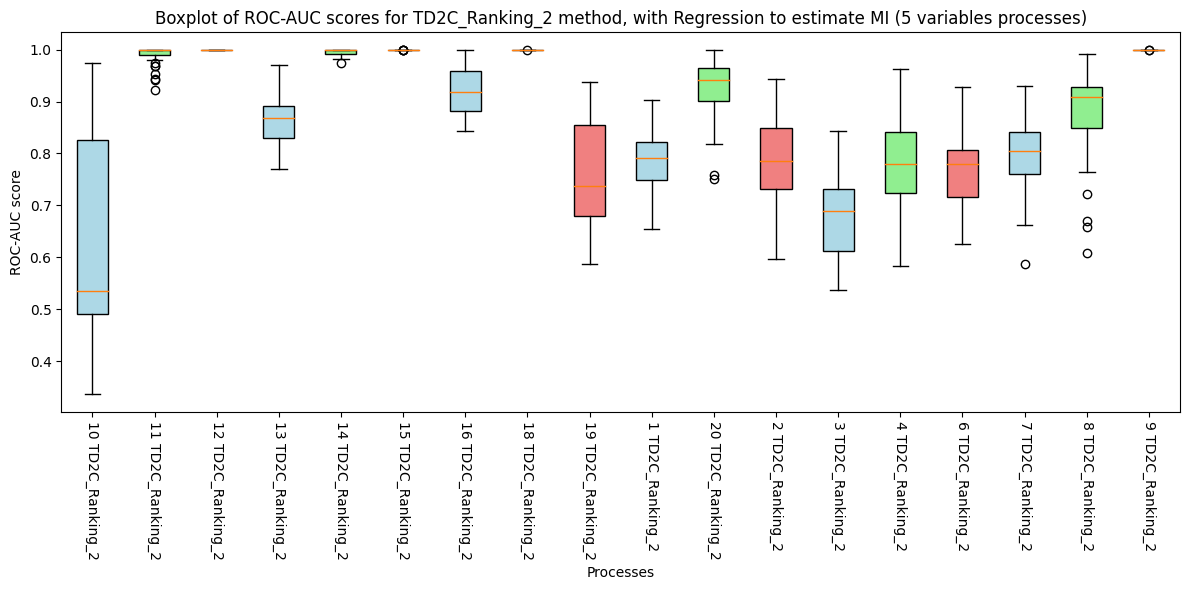

In [50]:
df1 = pd.DataFrame(globals()[m1])
df_name = f'{name}_rocs_dataset'
globals()[df_name] = df1

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} {name}')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title(f'Boxplot of ROC-AUC scores for {name} method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past-future (& TD2C in the past-future but without contrmporaneous nodes)

#### Descriptors Generation

In [19]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_PastFut/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts_past')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

100%|██████████| 18/18 [04:44<00:00, 15.79s/it]


#### Run Classifier

In [37]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_PastFut/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [38]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_rocs_process = {}
    td2c_past_precision_process = {}
    td2c_past_recall_process = {}
    td2c_past_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_rocs_process[gen_process_number] = rocs
        td2c_past_precision_process[gen_process_number] = precisions
        td2c_past_recall_process[gen_process_number] = recalls
        td2c_past_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/my

#### Save Results

In [39]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_R_N5.pkl'), 'wb') as f:
    everything = (td2c_past_rocs_process, td2c_past_precision_process, td2c_past_recall_process, td2c_past_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

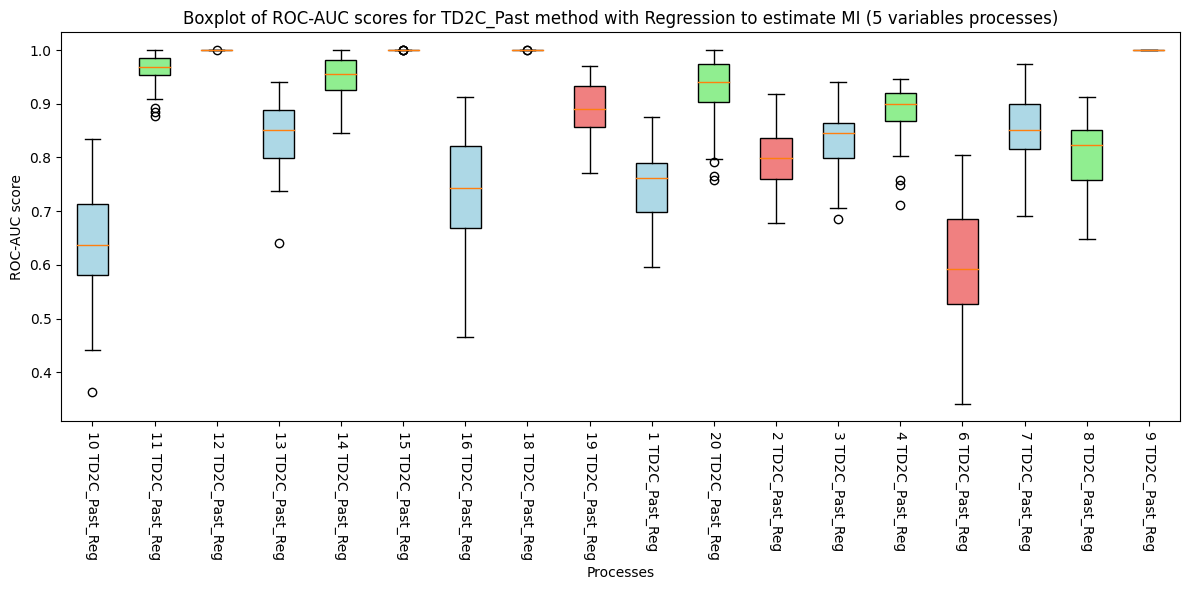

In [40]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    TD2C_Ranking_PastFut_rocs_process, TD2C_Ranking_PastFut_precision_process, TD2C_Ranking_PastFut_recall_process, TD2C_Ranking_PastFut_f1_process = pickle.load(f) 

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Past_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_Past method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

## KNNCMI Estimation of MI

### D2C (& D2C but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'original')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_K_rocs_process = {}
    d2c_K_precision_process = {}
    d2c_K_recall_process = {}
    d2c_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_K_rocs_process[gen_process_number] = rocs
        d2c_K_precision_process[gen_process_number] = precisions
        d2c_K_recall_process[gen_process_number] = recalls
        d2c_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_past method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C (& TD2C but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_K_rocs_process = {}
    td2c_K_precision_process = {}
    td2c_K_recall_process = {}
    td2c_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_K_rocs_process[gen_process_number] = rocs
        td2c_K_precision_process[gen_process_number] = precisions
        td2c_K_recall_process[gen_process_number] = recalls
        td2c_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking (& TD2C + Ranking but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'ts_rank',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run CLassifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rank_K_rocs_process = {}
    td2c_rank_K_precision_process = {}
    td2c_rank_K_recall_process = {}
    td2c_rank_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rank_K_rocs_process[gen_process_number] = rocs
        td2c_rank_K_precision_process[gen_process_number] = precisions
        td2c_rank_K_recall_process[gen_process_number] = recalls
        td2c_rank_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_rank_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_rank_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_rank method with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past-future (& TD2C in the past-future but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_Past/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn',
            mb_estimator= 'ts_rank',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_Past/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_K_rocs_process = {}
    td2c_past_K_precision_process = {}
    td2c_past_K_recall_process = {}
    td2c_past_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_K_rocs_process[gen_process_number] = rocs
        td2c_past_K_precision_process[gen_process_number] = precisions
        td2c_past_K_recall_process[gen_process_number] = recalls
        td2c_past_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores fro TD2C_past method with knnCMI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

# Plot all Results - Comparison

### ROC-AUC

#### Regression

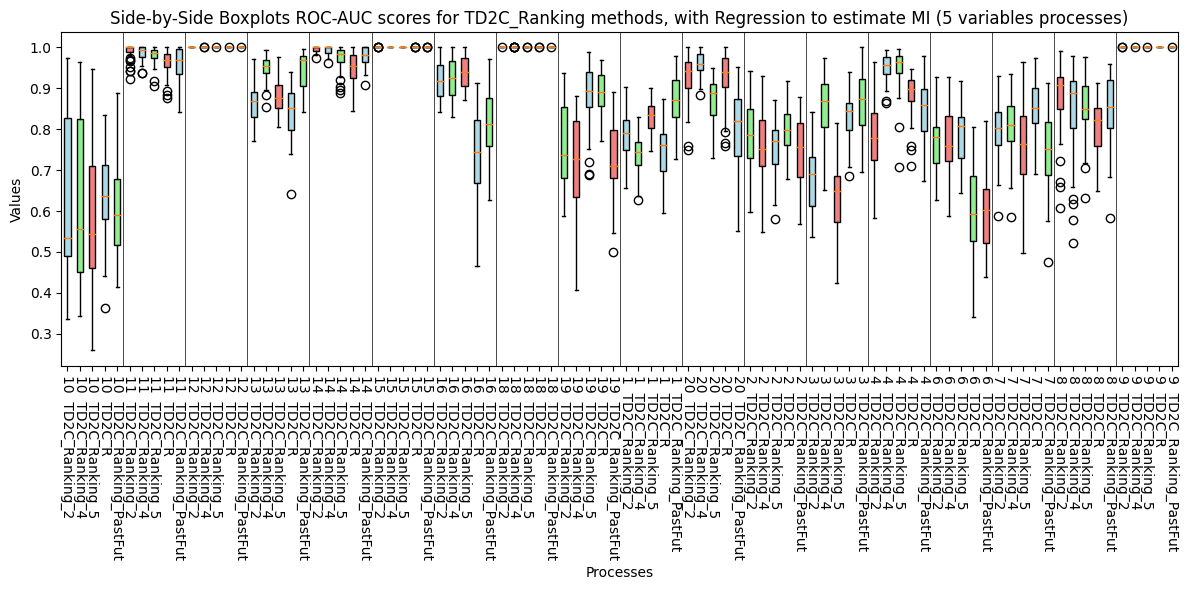

In [51]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
# df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
# df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
# df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
# df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
# df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df5.columns:
    # combined_data.append(df1[col])
    # combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    # combined_data.append(df6[col])
    combined_data.append(df11[col])
    # combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    # combined_data.append(df10[col])
    combined_data.append(df12[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    # labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    # labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    # labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    # labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    # labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    # labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    # labels.append(f'{col}  D2C_R')


# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# add a vertical line every 6 boxes
for i in range(5, len(labels), 5):
    plt.axvline(x=i+0.5, color='black', linewidth=0.5)

# save the plot as a pdf in folder
# plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/boxplot_TD2C_Ranking.pdf')

plt.show()

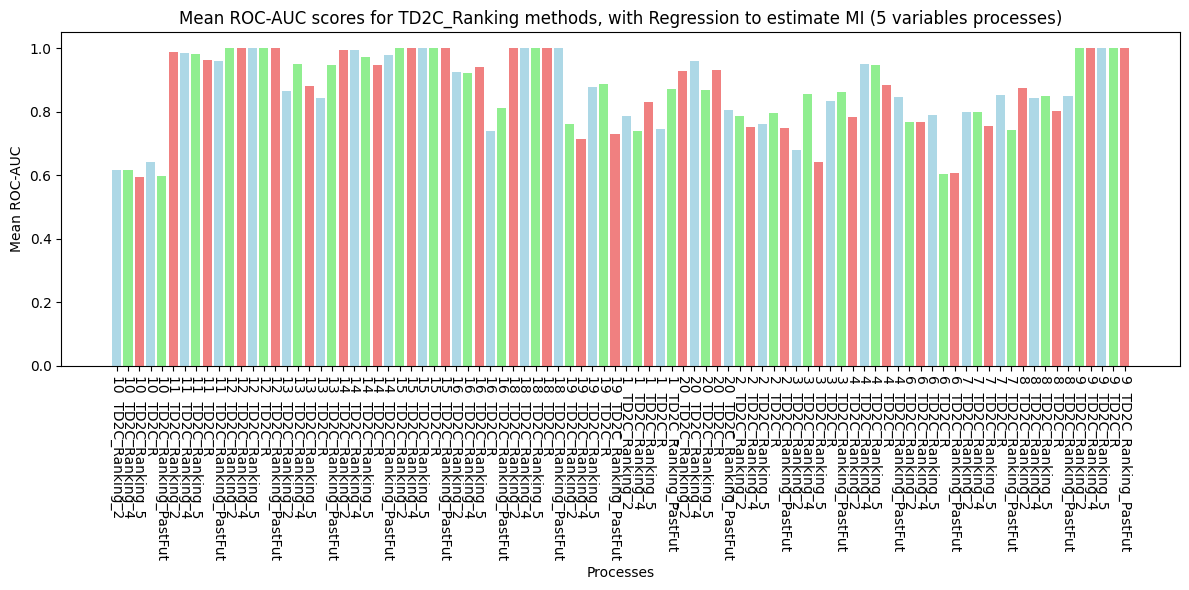

In [52]:
# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
means = [df.mean().mean() for df in combined_data]
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()


# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/barplot_TD2C_Ranking.pdf')

plt.show()

In [53]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
# df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
# df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
# df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
# df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
# df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)

# df1 = df1.T
# df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
# df6 = df6.T
# df7 = df7.T
df8 = df8.T
df9 = df9.T
# df10 = df10.T
df11 = df11.T
df12 = df12.T

# df1['method'] = 'TD2C_Ranking_1_1_Var'
# df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
# df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
# df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
# df10['method'] = 'D2C_R'

df = pd.concat([df5, df11, df12, df8, df9]) # df1, df2, df3, df4, df6, df7, df10

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='roc_auc')

df['roc_auc'] = df['roc_auc'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='roc_auc')

df = df.reset_index()

# df = df.rename(columns={'process_id': 'Process ID', 
#                         'TD2C_+Ranking_1_1_Var_rocs_process': 'TD2C_+Ranking_1_1_Var_rocs_process', 
#                         'TD2C_+Ranking_1_2_Var_rocs_process': 'TD2C_+Ranking_1_2_Var_rocs_process', 
#                         'TD2C_+Ranking_1_3_Var_rocs_process': 'TD2C_+Ranking_1_3_Var_rocs_process',
#                         'TD2C_+Ranking_1_10_Var_rocs_process': 'TD2C_+Ranking_1_10_Var_rocs_process', 
#                         'TD2C_+Ranking_2_rocs_process': 'TD2C_+Ranking_2_rocs_process', 
#                         'TD2C_+Ranking_3_rocs_process': 'TD2C_+Ranking_3_rocs_process',
#                         'TD2C_+Ranking_4_rocs_process': 'TD2C_+Ranking_4_rocs_process', 
#                         'TD2C_+Ranking_NoCont_rocs_process': 'TD2C_+Ranking_NoCont_rocs_process',
#                         'TD2C_R_rocs_process': 'TD2C_R_rocs_process',
#                         'TD2C_+Ranking_PastFut_rocs_process': 'TD2C_+Ranking_PastFut_rocs_process',
#                         'D2C_R_rocs_process': 'D2C_R_rocs_process'})

df = df.rename(columns={'process_id': 'Process ID',
                        'TD2C_+Ranking_2_rocs_process': 'TD2C_+Ranking_2_rocs_process',
                        'TD2C_+Ranking_4_rocs_process': 'TD2C_+Ranking_4_rocs_process',
                        'TD2C_+Ranking_5_rocs_process': 'TD2C_+Ranking_5_rocs_process',
                        'TD2C_R_rocs_process': 'TD2C_R_rocs_process',
                        'TD2C_+Ranking_PastFut_rocs_process': 'TD2C_+Ranking_PastFut_rocs_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv', index=False)

df

/tmp/ipykernel_25623/2232758575.py:50: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['process_id', 'method']).mean().reset_index()


method  Process ID    TD2C_R  TD2C_Ranking_2  TD2C_Ranking_4  TD2C_Ranking_5  \
0                1  0.831485        0.786540        0.738762        0.872446   
1                2  0.762302        0.787708        0.751823        0.748472   
2                3  0.640468        0.680382        0.855596        0.862550   
3                4  0.948410        0.782313        0.950989        0.847511   
4                6  0.788516        0.768492        0.766983        0.605880   
5                7  0.755143        0.798978        0.798718        0.743801   
6                8  0.850260        0.873245        0.842162        0.849258   
7                9  1.000000        1.000000        1.000000        1.000000   
8               10  0.592764        0.615599        0.615933        0.598305   
9               11  0.981141        0.989112        0.985297        0.959235   
10              12  1.000000        1.000000        1.000000        1.000000   
11              13  0.881405        0.864112        0.950026        0.946546   
12              14  0.972541        0.995334        0.993077        0.978102   
13              15  1.000000        1.000000        1.000000        1.000000   
14              16  0.940240        0.923685        0.922095        0.811255   
15              18  1.000000        1.000000        1.000000        1.000000   
16              19  0.879073        0.760191        0.714607        0.729082   
17              20  0.869475        0.927734        0.960295        0.804107   

method  TD2C_Ranking_PastFut  
0                   0.744201  
1                   0.796404  
2                   0.833735  
3                   0.883992  
4                   0.603968  
5                   0.853853  
6                   0.802810  
7                   1.000000  
8                   0.641167  
9                   0.962049  
10                  1.000000  
11                  0.842474  
12                  0.948524  
13                  1.000000  
14                  0.737865  
15                  1.000000  
16                  0.888072  
17                  0.930136

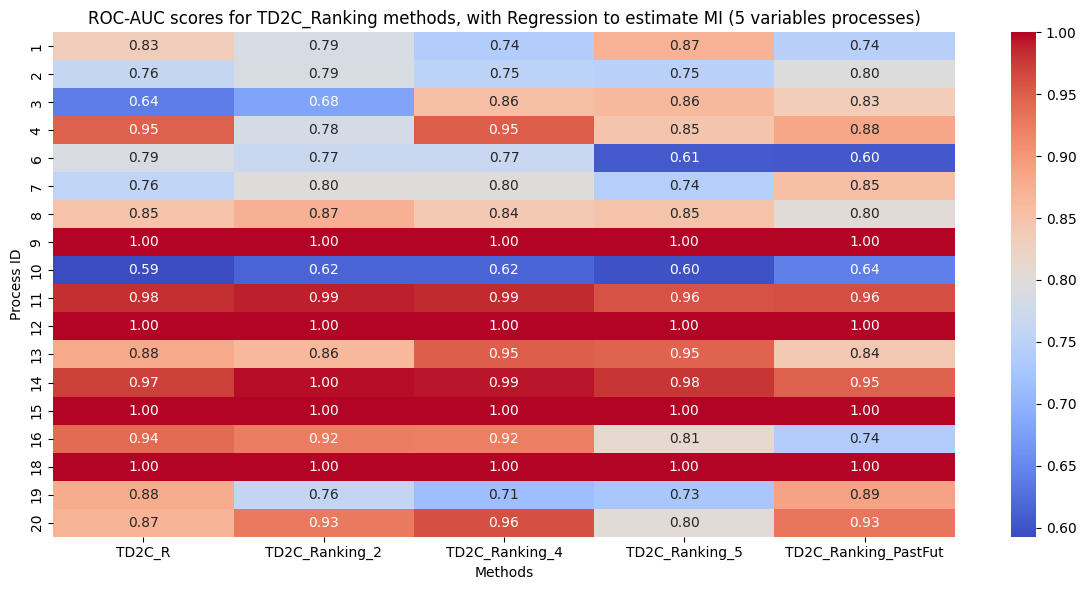

In [54]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/heatmap_TD2C_Ranking.pdf')

plt.show()

In [55]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'roc_auc'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_mean_proc.csv', index=False)

df

Process ID   roc_auc
0            1  0.794687
1            2  0.769342
2            3  0.774546
3            4  0.882643
4            6  0.706768
5            7  0.790099
6            8  0.843547
7            9  1.000000
8           10  0.612753
9           11  0.975367
10          12  1.000000
11          13  0.896913
12          14  0.977516
13          15  1.000000
14          16  0.867028
15          18  1.000000
16          19  0.794205
17          20  0.898349

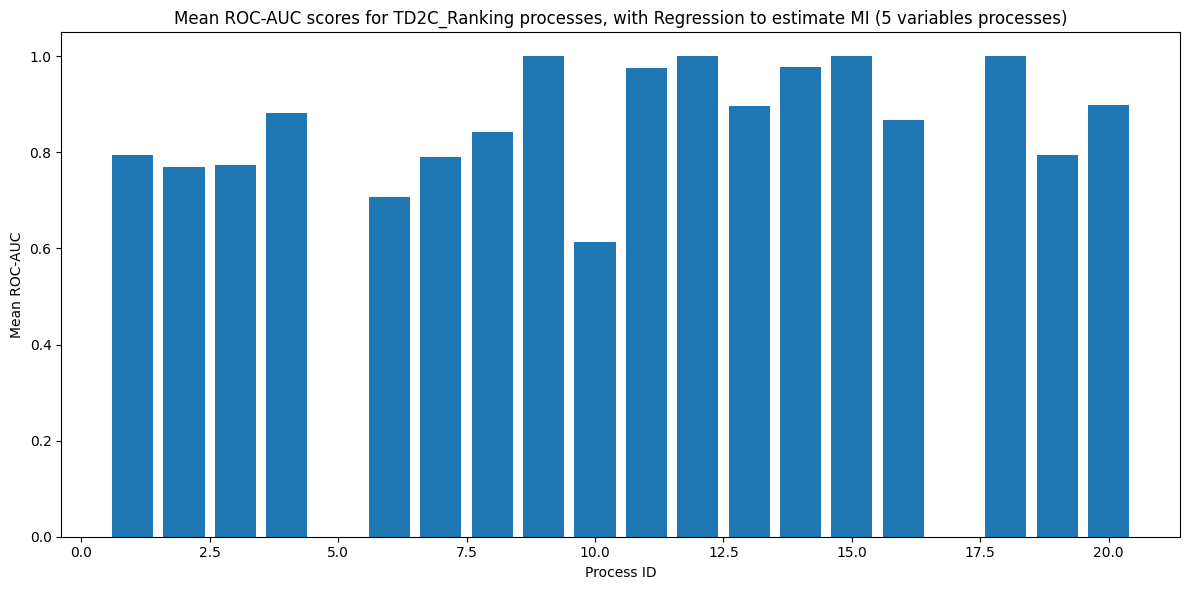

In [56]:
# plot the dataframe as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['roc_auc'])
plt.title('Mean ROC-AUC scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [57]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'roc_auc'})

df = df.sort_values(by='roc_auc', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv', index=False)

df

method   roc_auc
1        TD2C_Ranking_4  0.880354
2                TD2C_R  0.871846
3        TD2C_Ranking_2  0.864079
4  TD2C_Ranking_PastFut  0.859403
5        TD2C_Ranking_5  0.853142

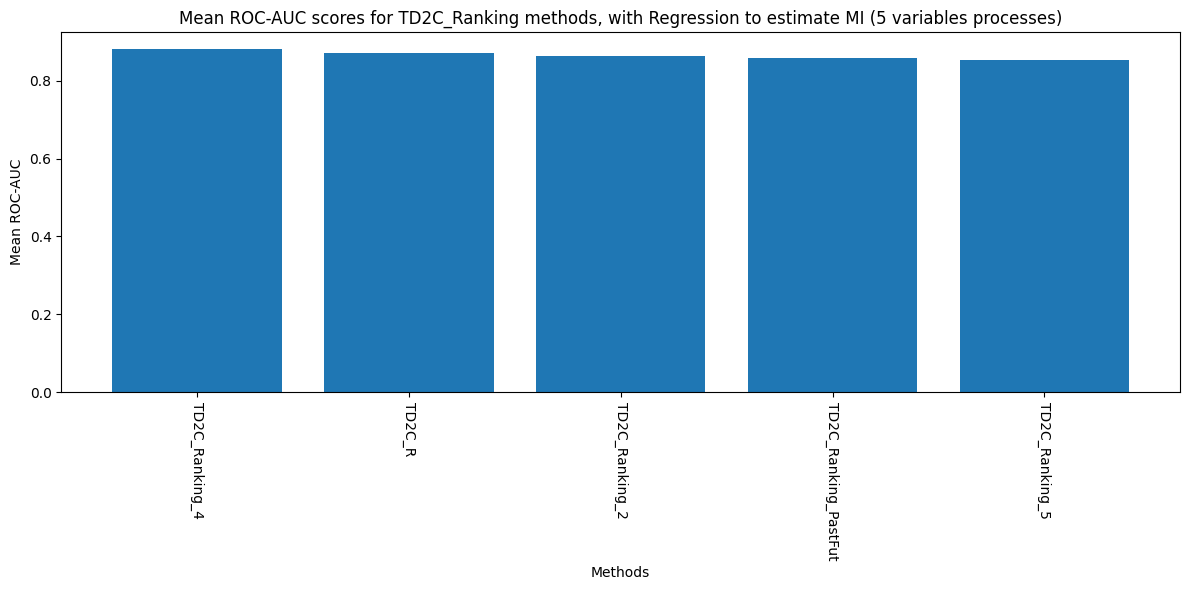

In [58]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['roc_auc'])
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/barplot_TD2C_Ranking_avg.pdf')

plt.show()

### Precision

#### Regression

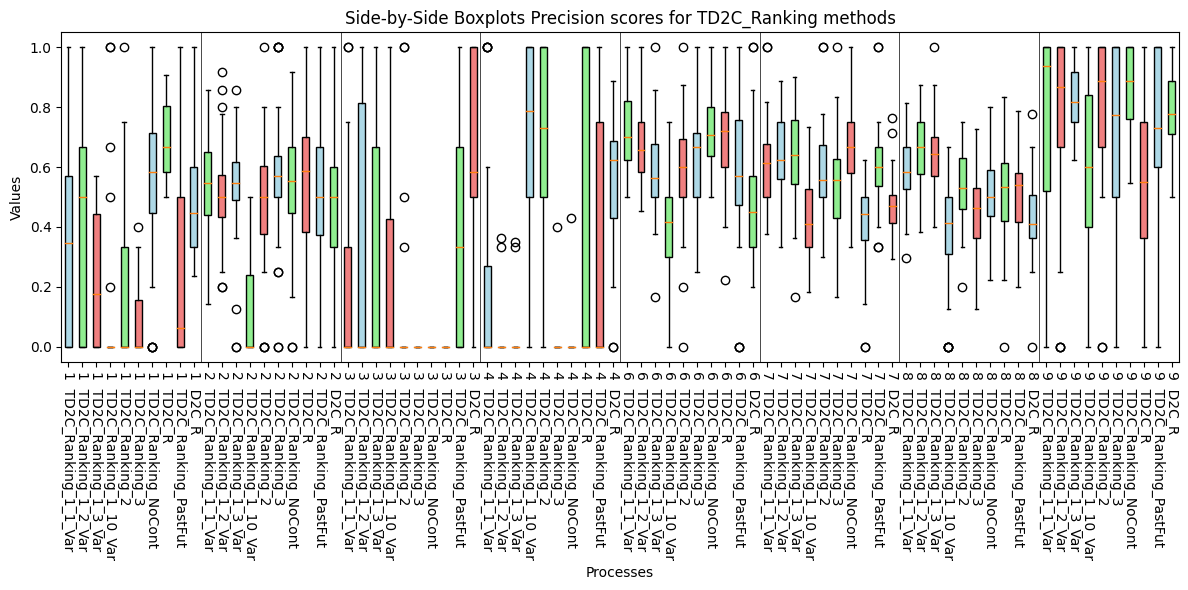

In [187]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_Ranking_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_R_precision_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Precision scores for TD2C_Ranking methods')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# add a vertical line every 6 boxes
for i in range(10, len(labels), 10):
    plt.axvline(x=i+0.5, color='black', linewidth=0.5)

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/boxplot_TD2C_Ranking_precision.pdf')

plt.show()

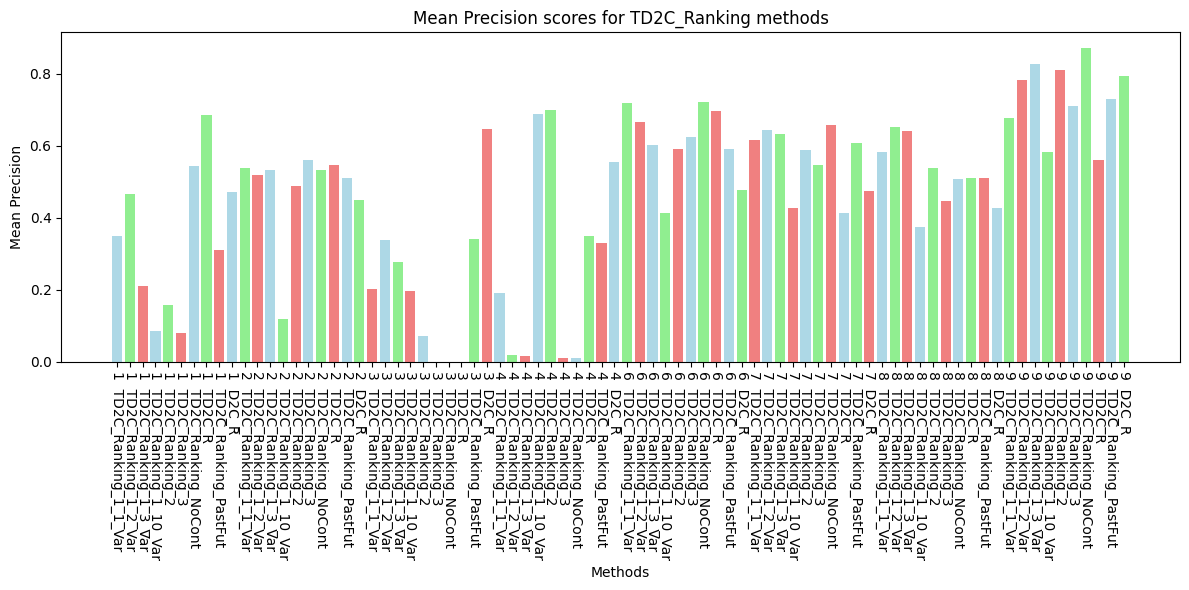

In [188]:
# Plotting Barplot
mean_values = []
for data in combined_data:
    mean_values.append(np.mean(data))

plt.figure(figsize=(12, 6))

plt.bar(labels, mean_values, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_precision.pdf')

plt.show()

In [189]:
# NOW SHOW THE PRECISION RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_Ranking_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_R_precision_process)

df1 = df1.T
df2 = df2.T
df3 = df3.T
df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
df3['method'] = 'TD2C_Ranking_1_3_Var'
df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='precision')

df['precision'] = df['precision'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='precision')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID',
                        'TD2C_Ranking_1_1_Var_precision_process': 'TD2C_Ranking_1_1_Var_precision_process',
                        'TD2C_Ranking_1_2_Var_precision_process': 'TD2C_Ranking_1_2_Var_precision_process',
                        'TD2C_Ranking_1_3_Var_precision_process': 'TD2C_Ranking_1_3_Var_precision_process',
                        'TD2C_Ranking_1_10_Var_precision_process': 'TD2C_Ranking_1_10_Var_precision_process',
                        'TD2C_Ranking_2_precision_process': 'TD2C_Ranking_2_precision_process',
                        'TD2C_Ranking_3_precision_process': 'TD2C_Ranking_3_precision_process',
                        'TD2C_Ranking_NoCont_precision_process': 'TD2C_Ranking_NoCont_precision_process',
                        'TD2C_R_precision_process': 'TD2C_R_precision_process',
                        'TD2C_Ranking_PastFut_precision_process': 'TD2C_Ranking_PastFut_precision_process',
                        'D2C_R_precision_process': 'D2C_R_precision_process'})


# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking.csv', index=False)

df

/tmp/ipykernel_37005/2425469640.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['process_id', 'method']).mean().reset_index()


method  Process ID     D2C_R    TD2C_R  TD2C_Ranking_1_10_Var  \
0                1  0.471779  0.686992               0.084167   
1                2  0.449859  0.548084               0.120070   
2                3  0.646667  0.000000               0.196458   
3                4  0.554700  0.350625               0.688151   
4                6  0.477305  0.696567               0.412907   
5                7  0.474309  0.414308               0.427670   
6                8  0.426210  0.510667               0.373571   
7                9  0.793215  0.559913               0.584236   

method  TD2C_Ranking_1_1_Var  TD2C_Ranking_1_2_Var  TD2C_Ranking_1_3_Var  \
0                   0.349766              0.466860              0.210134   
1                   0.537127              0.520063              0.531612   
2                   0.201667              0.337917              0.276786   
3                   0.189980              0.017424              0.017083   
4                   0.717775              0.665670              0.602064   
5                   0.616098              0.642952              0.634189   
6                   0.583592              0.653726              0.641169   
7                   0.677827              0.782312              0.828712   

method  TD2C_Ranking_2  TD2C_Ranking_3  TD2C_Ranking_NoCont  \
0             0.157431        0.080754             0.544455   
1             0.487972        0.561545             0.533127   
2             0.070833        0.000000             0.000000   
3             0.700225        0.010000             0.010714   
4             0.590032        0.625435             0.720938   
5             0.587871        0.545468             0.657972   
6             0.537510        0.445405             0.508926   
7             0.811934        0.709598             0.871989   

method  TD2C_Ranking_PastFut  
0                   0.311875  
1                   0.510853  
2                   0.340655  
3                   0.329663  
4                   0.590827  
5                   0.607842  
6                   0.510006  
7                   0.729121

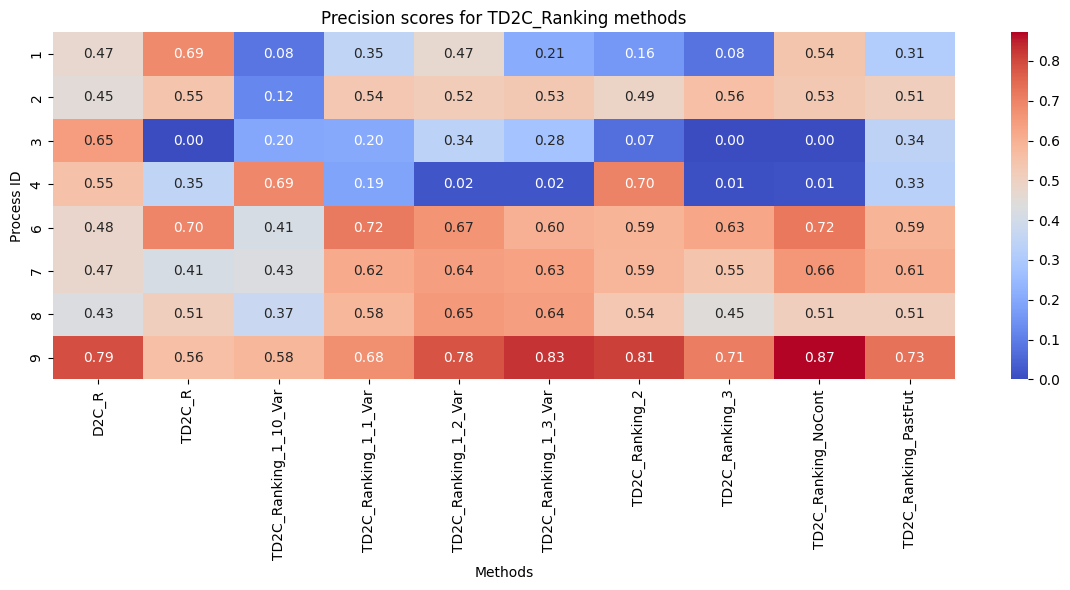

In [190]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Precision scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/heatmap_TD2C_Ranking_precision.pdf')

plt.show()

In [191]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'precision'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking_mean_proc.csv', index=False)

df

Process ID  precision
0           1   0.336421
1           2   0.480031
2           3   0.207098
3           4   0.286857
4           6   0.609952
5           7   0.560868
6           8   0.519078
7           9   0.734886

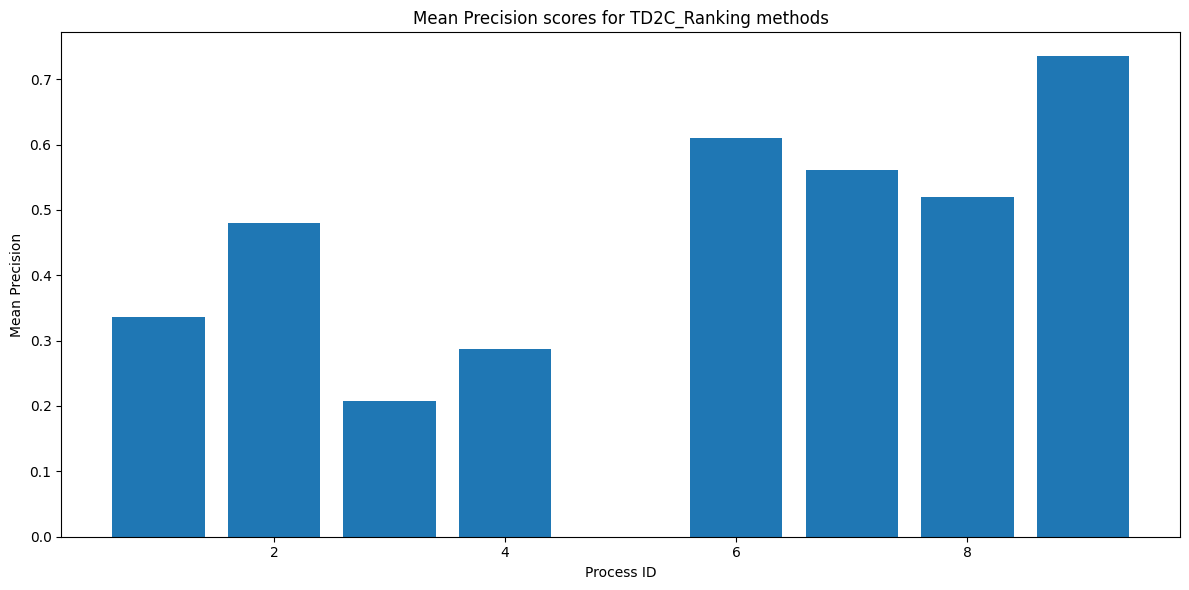

In [192]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking_mean_proc.csv')

# plot the dataframe as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['precision'])
plt.title('Mean Precision scores for TD2C_Ranking methods')
plt.xlabel('Process ID')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_precision_mean_proc.pdf')

plt.show()


In [193]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'precision'})

df = df.sort_values(by='precision', ascending=False)

df = df.reset_index(drop=True)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking_avg.csv', index=False)

df


method  precision
0              Process ID   5.000000
1                   D2C_R   0.536756
2    TD2C_Ranking_1_2_Var   0.510865
3          TD2C_Ranking_2   0.492976
4    TD2C_Ranking_PastFut   0.491355
5    TD2C_Ranking_1_1_Var   0.484229
6     TD2C_Ranking_NoCont   0.481015
7                  TD2C_R   0.470894
8    TD2C_Ranking_1_3_Var   0.467719
9          TD2C_Ranking_3   0.372276
10  TD2C_Ranking_1_10_Var   0.360904

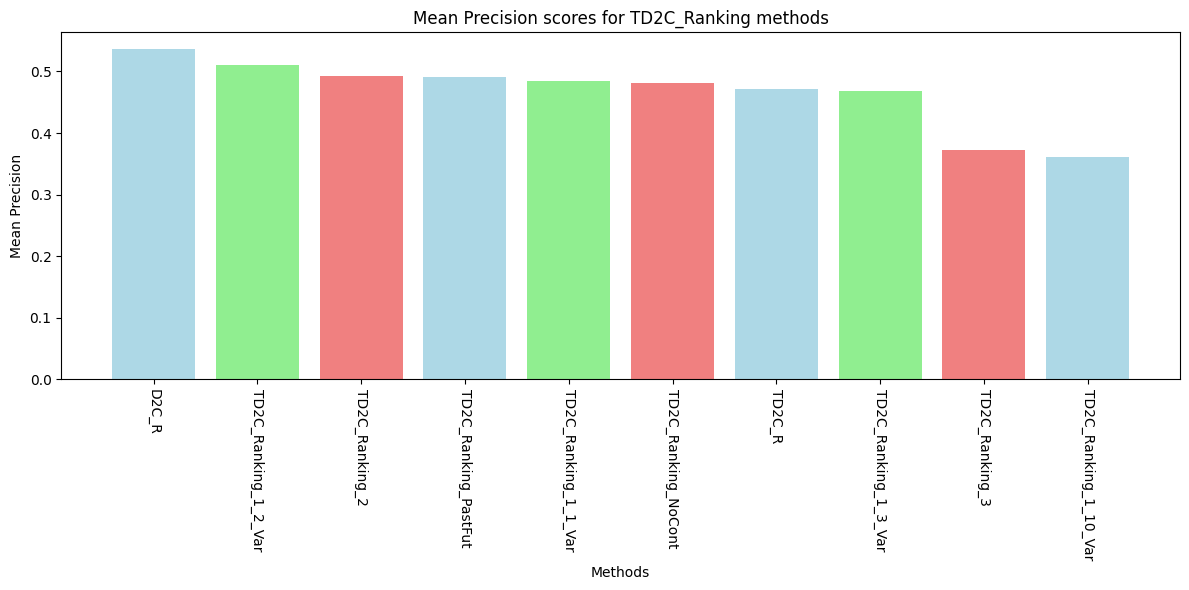

In [194]:
# load the data from csv files
df_prec = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking_avg.csv')

# Barplot for precision scores from index 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df_prec['method'][1:], df_prec['precision'][1:], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_precision_avg.pdf')

plt.show()

### Recall

#### Regression

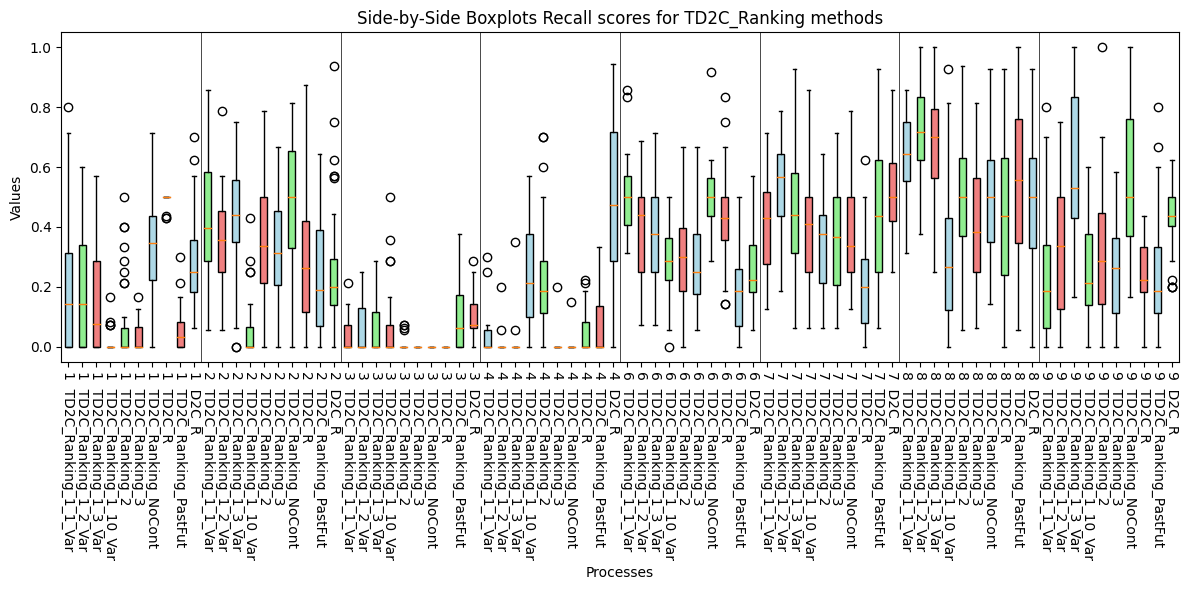

In [195]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_Ranking_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_R_recall_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Recall scores for TD2C_Ranking methods')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# add a vertical line every 6 boxes
for i in range(10, len(labels), 10):
    plt.axvline(x=i+0.5, color='black', linewidth=0.5)

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/boxplot_TD2C_Ranking_recall.pdf')

plt.show()

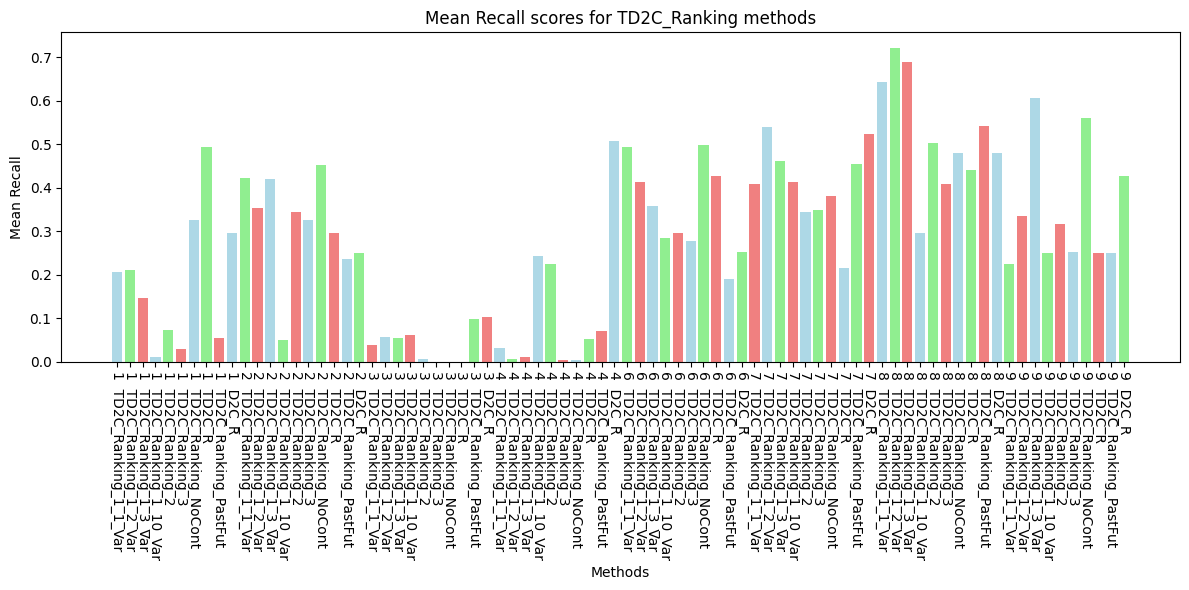

In [196]:
# Plotting Barplot
mean_values = []
for data in combined_data:
    mean_values.append(np.mean(data))

plt.figure(figsize=(12, 6))
plt.bar(labels, mean_values, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_recall.pdf')

plt.show()

In [197]:
# NOW SHOW THE RECALL RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_Ranking_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_R_recall_process)

df1 = df1.T
df2 = df2.T
df3 = df3.T
df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
df3['method'] = 'TD2C_Ranking_1_3_Var'
df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'


df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

df = df.reset_index()

df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='recall')

df['recall'] = df['recall'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='recall')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID',
                        'TD2C_Ranking_1_1_Var_recall_process': 'TD2C_Ranking_1_1_Var_recall_process',
                        'TD2C_Ranking_1_2_Var_recall_process': 'TD2C_Ranking_1_2_Var_recall_process',
                        'TD2C_Ranking_1_3_Var_recall_process': 'TD2C_Ranking_1_3_Var_recall_process',
                        'TD2C_Ranking_1_10_Var_recall_process': 'TD2C_Ranking_1_10_Var_recall_process',
                        'TD2C_Ranking_2_recall_process': 'TD2C_Ranking_2_recall_process',
                        'TD2C_Ranking_3_recall_process': 'TD2C_Ranking_3_recall_process',
                        'TD2C_Ranking_NoCont_recall_process': 'TD2C_Ranking_NoCont_recall_process',
                        'TD2C_R_recall_process': 'TD2C_R_recall_process',
                        'TD2C_Ranking_PastFut_recall_process': 'TD2C_Ranking_PastFut_recall_process',
                        'D2C_R_recall_process': 'D2C_R_recall_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking.csv', index=False)

df

/tmp/ipykernel_37005/591526913.py:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['process_id', 'method']).mean().reset_index()


method  Process ID     D2C_R    TD2C_R  TD2C_Ranking_1_10_Var  \
0                1  0.296136  0.494866               0.011607   
1                2  0.249876  0.295139               0.050744   
2                3  0.102207  0.000000               0.060491   
3                4  0.507138  0.051389               0.242480   
4                6  0.252455  0.426116               0.283433   
5                7  0.523338  0.216592               0.414162   
6                8  0.480729  0.441195               0.296999   
7                9  0.427946  0.250764               0.251017   

method  TD2C_Ranking_1_1_Var  TD2C_Ranking_1_2_Var  TD2C_Ranking_1_3_Var  \
0                   0.205610              0.211488              0.147312   
1                   0.421875              0.352480              0.419345   
2                   0.038294              0.057862              0.055580   
3                   0.032525              0.006389              0.010139   
4                   0.493502              0.413889              0.357961   
5                   0.408061              0.539385              0.461012   
6                   0.643056              0.721404              0.690055   
7                   0.224360              0.335372              0.606057   

method  TD2C_Ranking_2  TD2C_Ranking_3  TD2C_Ranking_NoCont  \
0             0.073690        0.028586             0.326265   
1             0.343378        0.326587             0.451463   
2             0.006523        0.000000             0.000000   
3             0.225561        0.005000             0.003750   
4             0.295139        0.277927             0.498859   
5             0.345238        0.349157             0.380903   
6             0.502604        0.409301             0.480952   
7             0.317312        0.253313             0.560263   

method  TD2C_Ranking_PastFut  
0                   0.055313  
1                   0.235838  
2                   0.097569  
3                   0.070561  
4                   0.190179  
5                   0.455828  
6                   0.541146  
7                   0.249836

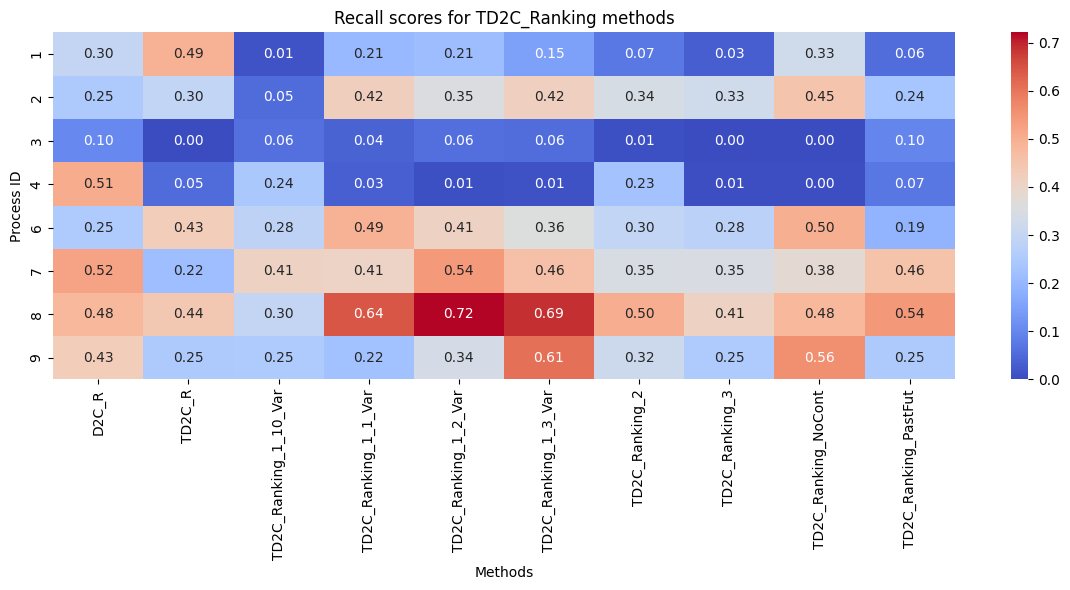

In [198]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Recall scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/heatmap_TD2C_Ranking_recall.pdf')

plt.show()

In [199]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'recall'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking_mean_proc.csv', index=False)

df

Process ID    recall
0           1  0.185087
1           2  0.314673
2           3  0.041853
3           4  0.115493
4           6  0.348946
5           7  0.409368
6           8  0.520744
7           9  0.347624

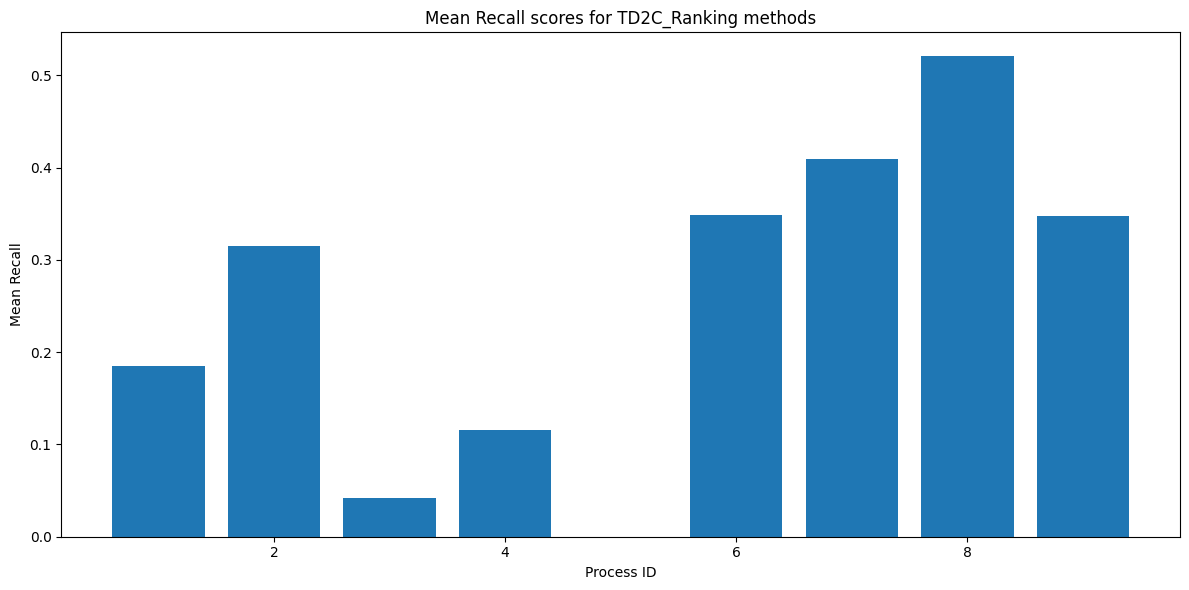

In [200]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking_mean_proc.csv')


# plot the dataframe as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['recall'])
plt.title('Mean Recall scores for TD2C_Ranking methods')
plt.xlabel('Process ID')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_recall_mean_proc.pdf')

plt.show()

In [201]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking.csv')


# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'recall'})

df = df.sort_values(by='recall', ascending=False)

df = df.reset_index(drop=True)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking_avg.csv', index=False)

df

method    recall
0              Process ID  5.000000
1                   D2C_R  0.354978
2    TD2C_Ranking_1_3_Var  0.343433
3     TD2C_Ranking_NoCont  0.337807
4    TD2C_Ranking_1_2_Var  0.329784
5    TD2C_Ranking_1_1_Var  0.308410
6                  TD2C_R  0.272008
7          TD2C_Ranking_2  0.263681
8    TD2C_Ranking_PastFut  0.237034
9          TD2C_Ranking_3  0.206234
10  TD2C_Ranking_1_10_Var  0.201367

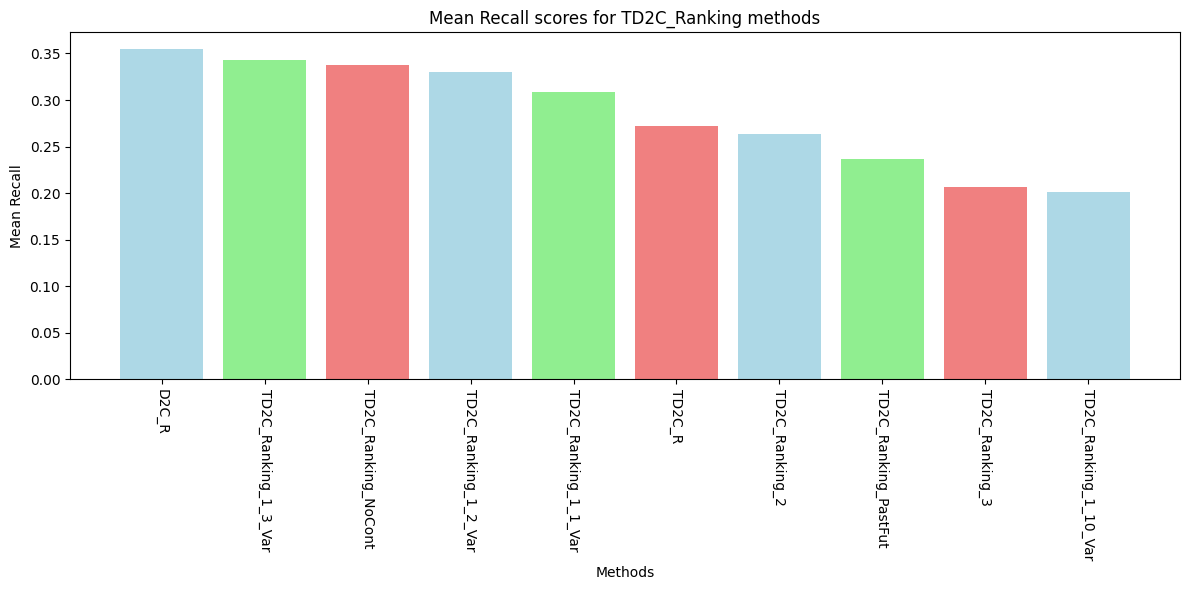

In [202]:
# load the data from csv files
df_recall = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking_avg.csv')

# Barplot for recall scores from index 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df_recall['method'][1:], df_recall['recall'][1:], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_recall_avg.pdf')

plt.show()

### F1

#### Regression

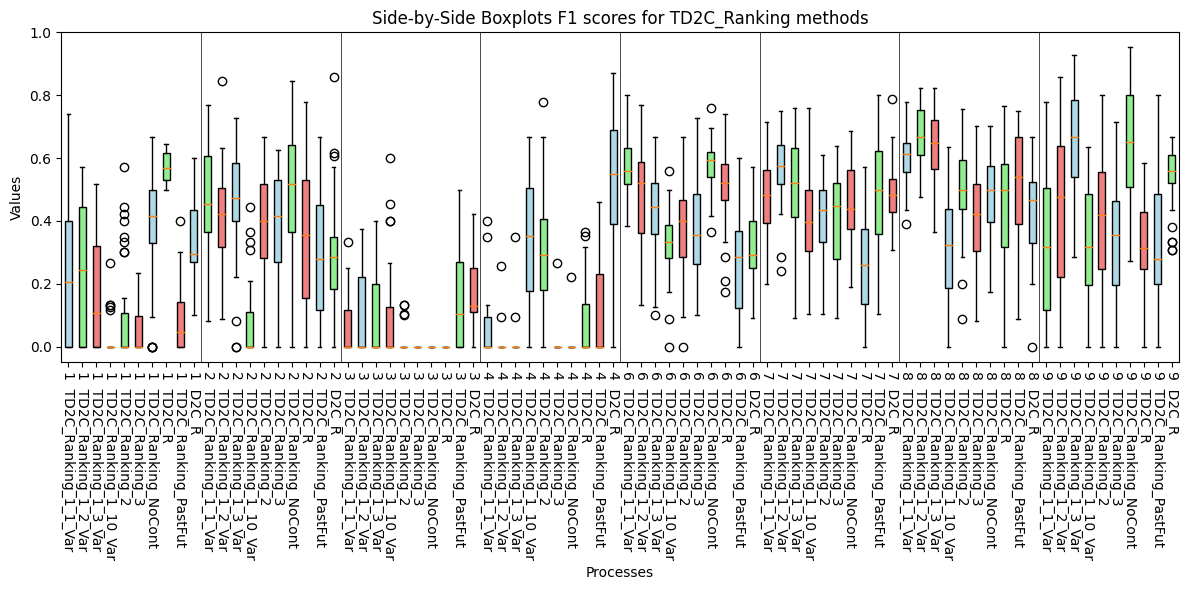

In [203]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_Ranking_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_R_f1_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])

# Create labels for x-axis
labels = []

for col in df1.columns:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']

for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots F1 scores for TD2C_Ranking methods')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# add a vertical line every 6 boxes
for i in range(10, len(labels), 10):
    plt.axvline(x=i+0.5, color='black', linewidth=0.5)

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/boxplot_TD2C_Ranking_f1.pdf')

plt.show()


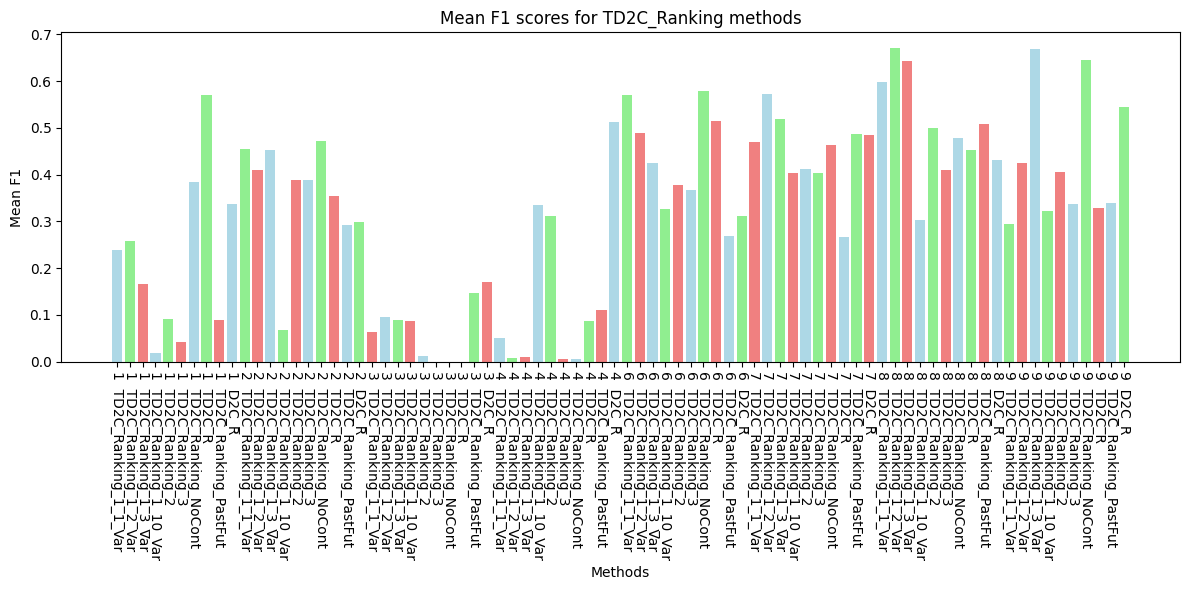

In [204]:
# Plotting Barplot
mean_values = []
for data in combined_data:
    mean_values.append(np.mean(data))

plt.figure(figsize=(12, 6))
plt.bar(labels, mean_values, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_f1.pdf')

plt.show()

In [205]:
# NOW SHOW THE F1 RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_Ranking_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_R_f1_process)

df1 = df1.T
df2 = df2.T
df3 = df3.T
df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
df3['method'] = 'TD2C_Ranking_1_3_Var'
df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='f1')

df['f1'] = df['f1'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='f1')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID',
                        'TD2C_Ranking_1_1_Var_f1_process': 'TD2C_Ranking_1_1_Var_f1_process',
                        'TD2C_Ranking_1_2_Var_f1_process': 'TD2C_Ranking_1_2_Var_f1_process',
                        'TD2C_Ranking_1_3_Var_f1_process': 'TD2C_Ranking_1_3_Var_f1_process',
                        'TD2C_Ranking_1_10_Var_f1_process': 'TD2C_Ranking_1_10_Var_f1_process',
                        'TD2C_Ranking_2_f1_process': 'TD2C_Ranking_2_f1_process',
                        'TD2C_Ranking_3_f1_process': 'TD2C_Ranking_3_f1_process',
                        'TD2C_Ranking_NoCont_f1_process': 'TD2C_Ranking_NoCont_f1_process',
                        'TD2C_R_f1_process': 'TD2C_R_f1_process',
                        'TD2C_Ranking_PastFut_f1_process': 'TD2C_Ranking_PastFut_f1_process',
                        'D2C_R_f1_process': 'D2C_R_f1_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking.csv', index=False)

df

/tmp/ipykernel_37005/1352930737.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['process_id', 'method']).mean().reset_index()


method  Process ID     D2C_R    TD2C_R  TD2C_Ranking_1_10_Var  \
0                1  0.337577  0.570932               0.019400   
1                2  0.297721  0.353797               0.066962   
2                3  0.170695  0.000000               0.086969   
3                4  0.513656  0.086748               0.335623   
4                6  0.312641  0.514442               0.326218   
5                7  0.485115  0.267570               0.402918   
6                8  0.431065  0.453755               0.302471   
7                9  0.544894  0.328336               0.321462   

method  TD2C_Ranking_1_1_Var  TD2C_Ranking_1_2_Var  TD2C_Ranking_1_3_Var  \
0                   0.239623              0.257405              0.166167   
1                   0.455612              0.409353              0.453694   
2                   0.063514              0.096275              0.089830   
3                   0.050633              0.008833              0.011131   
4                   0.571218              0.489654              0.424884   
5                   0.470536              0.571569              0.518537   
6                   0.598087              0.670822              0.643279   
7                   0.295490              0.424840              0.667685   

method  TD2C_Ranking_2  TD2C_Ranking_3  TD2C_Ranking_NoCont  \
0             0.092252        0.041124             0.384798   
1             0.388329        0.387857             0.471880   
2             0.011798        0.000000             0.000000   
3             0.311380        0.006667             0.005556   
4             0.378811        0.367014             0.579747   
5             0.411245        0.404092             0.463395   
6             0.499355        0.409189             0.478409   
7             0.406126        0.337959             0.646057   

method  TD2C_Ranking_PastFut  
0                   0.088362  
1                   0.292850  
2                   0.147395  
3                   0.109670  
4                   0.269516  
5                   0.486521  
6                   0.507853  
7                   0.338972

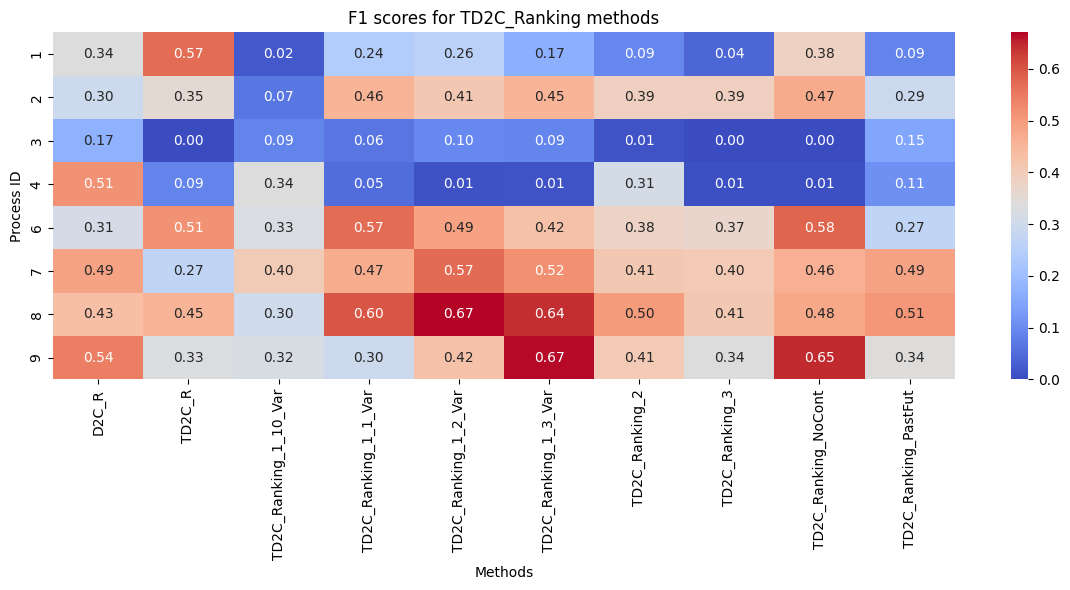

In [206]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('F1 scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/heatmap_TD2C_Ranking_f1.pdf')

plt.show()

In [207]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'f1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking_mean_proc.csv', index=False)

df

Process ID        f1
0           1  0.219764
1           2  0.357806
2           3  0.066648
3           4  0.143990
4           6  0.423414
5           7  0.448150
6           8  0.499428
7           9  0.431182

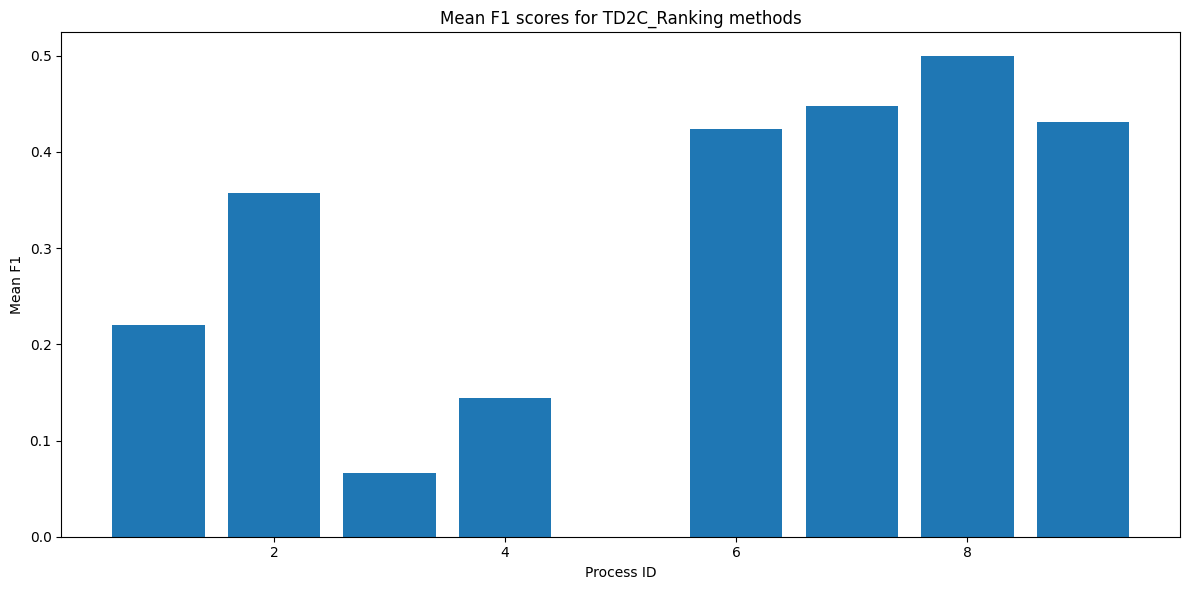

In [208]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking_mean_proc.csv')

# plot the dataframe as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['f1'])
plt.title('Mean F1 scores for TD2C_Ranking methods')
plt.xlabel('Process ID')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_f1_mean_proc.pdf')

plt.show()

In [209]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking.csv')


# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'f1'})

df = df.sort_values(by='f1', ascending=False)

df = df.reset_index(drop=True)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking_avg.csv', index=False)

df

method        f1
0              Process ID  5.000000
1                   D2C_R  0.386671
2     TD2C_Ranking_NoCont  0.378730
3    TD2C_Ranking_1_3_Var  0.371901
4    TD2C_Ranking_1_2_Var  0.366094
5    TD2C_Ranking_1_1_Var  0.343089
6                  TD2C_R  0.321947
7          TD2C_Ranking_2  0.312412
8    TD2C_Ranking_PastFut  0.280142
9          TD2C_Ranking_3  0.244237
10  TD2C_Ranking_1_10_Var  0.232753

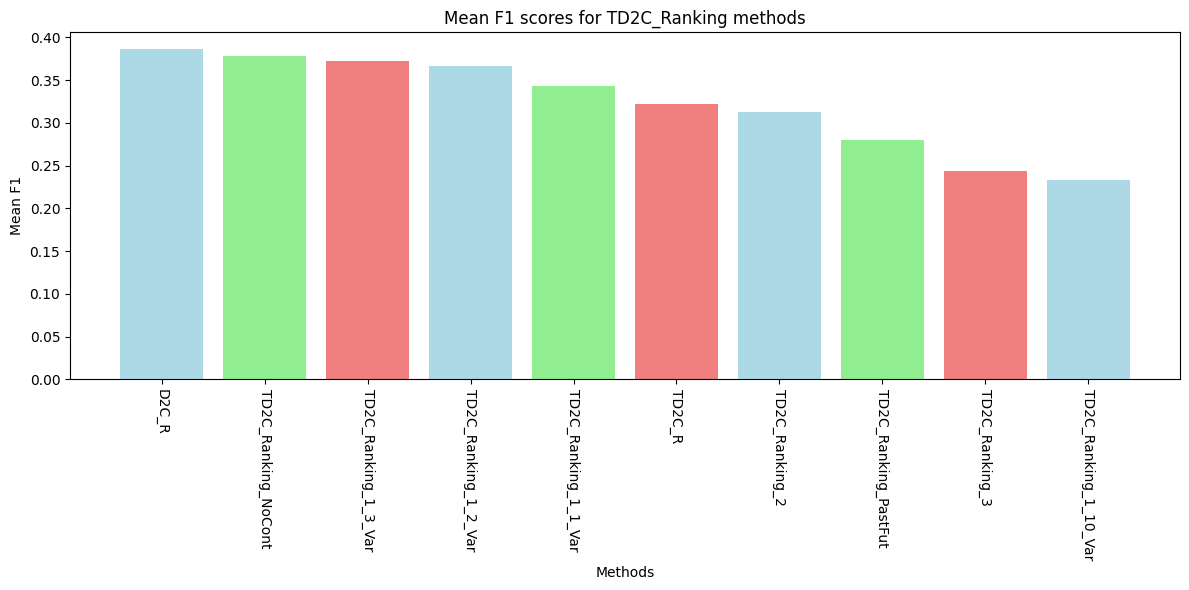

In [210]:
# load the data from csv files
df_f1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking_avg.csv')

# Barplot for f1 scores from index 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df_f1['method'][1:], df_f1['f1'][1:], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_f1_avg.pdf')

plt.show()